Raw columns : ['Date', 'Price']
Shape       : (5686, 2)

Date range  : 2010-07-17 → 2026-02-08
Price range : $0.0495 – $124,641.52
Points      : 5686

QUANTILE REGRESSION   log₁₀(price) = α + β · log₁₀(years)
  Q10%: price = 3.7100e-03 × t^5.9133   (α=-2.4306, β=5.9133)
  Q20%: price = 4.0720e-03 × t^5.9259   (α=-2.3902, β=5.9259)
  Q30%: price = 4.5291e-03 × t^5.9288   (α=-2.3440, β=5.9288)
  Q40%: price = 5.3301e-03 × t^5.9095   (α=-2.2733, β=5.9095)
  Q50%: price = 6.8962e-03 × t^5.8665   (α=-2.1614, β=5.8665)
  Q60%: price = 1.3071e-02 × t^5.6824   (α=-1.8837, β=5.6824)
  Q70%: price = 2.8166e-02 × t^5.4265   (α=-1.5503, β=5.4265)
  Q80%: price = 7.3830e-02 × t^5.1144   (α=-1.1318, β=5.1144)
  Q90%: price = 1.3151e-01 × t^5.0141   (α=-0.8811, β=5.0141)

Latest data (2026-02-08):  t = 17.114 yr,  price = $70,377
  Q10% model = $72,875   → actual is 0.97× the Q10% line
  Q20% model = $82,905   → actual is 0.85× the Q20% line
  Q30% model = $92,979   → actual is 0.76× the Q30% line
  

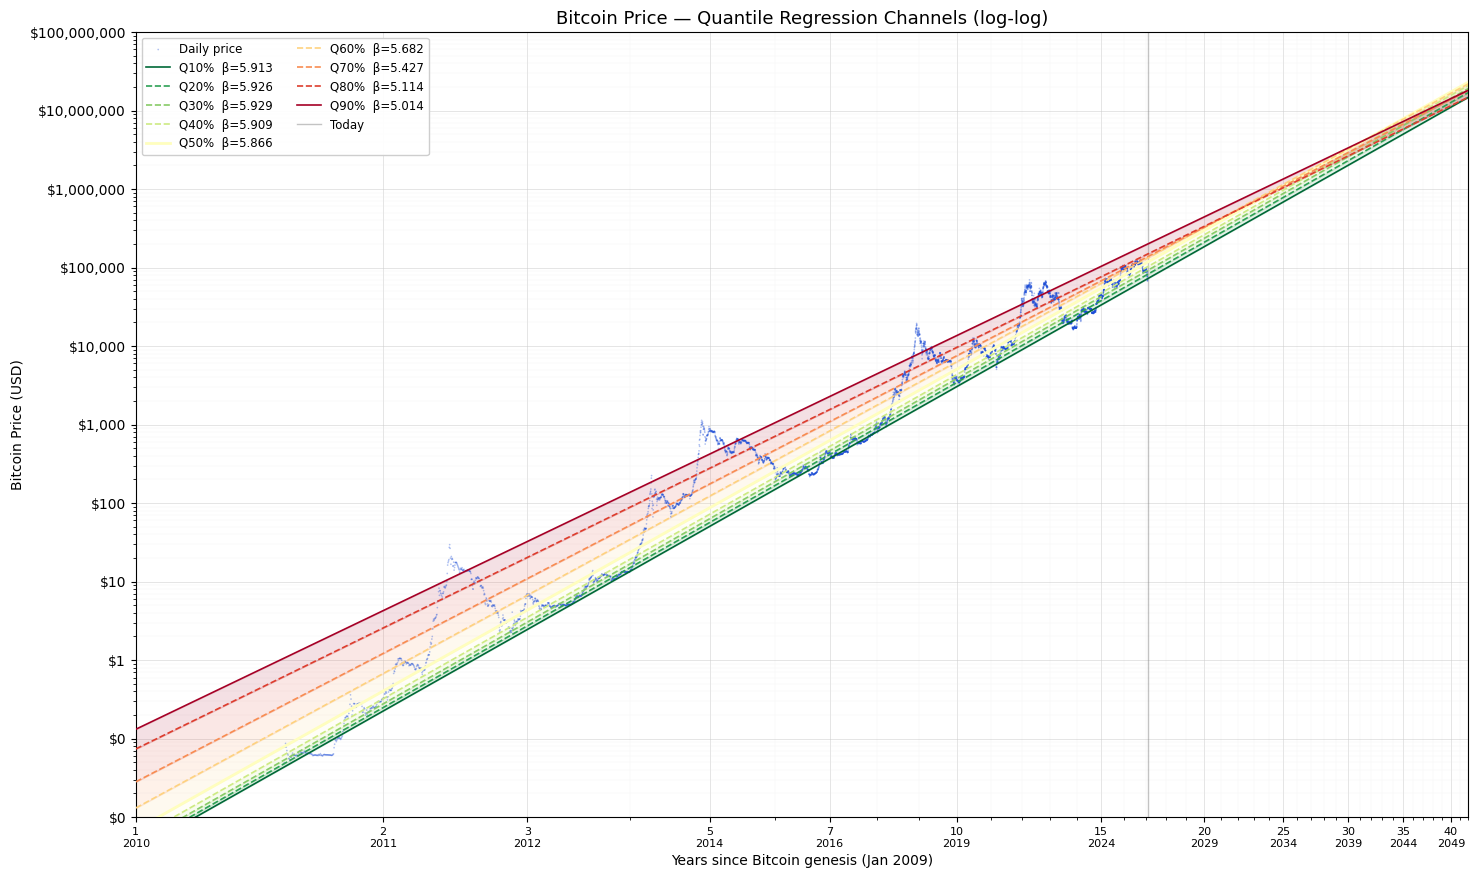

  Saved qr_normalized_position.svg / .jpg


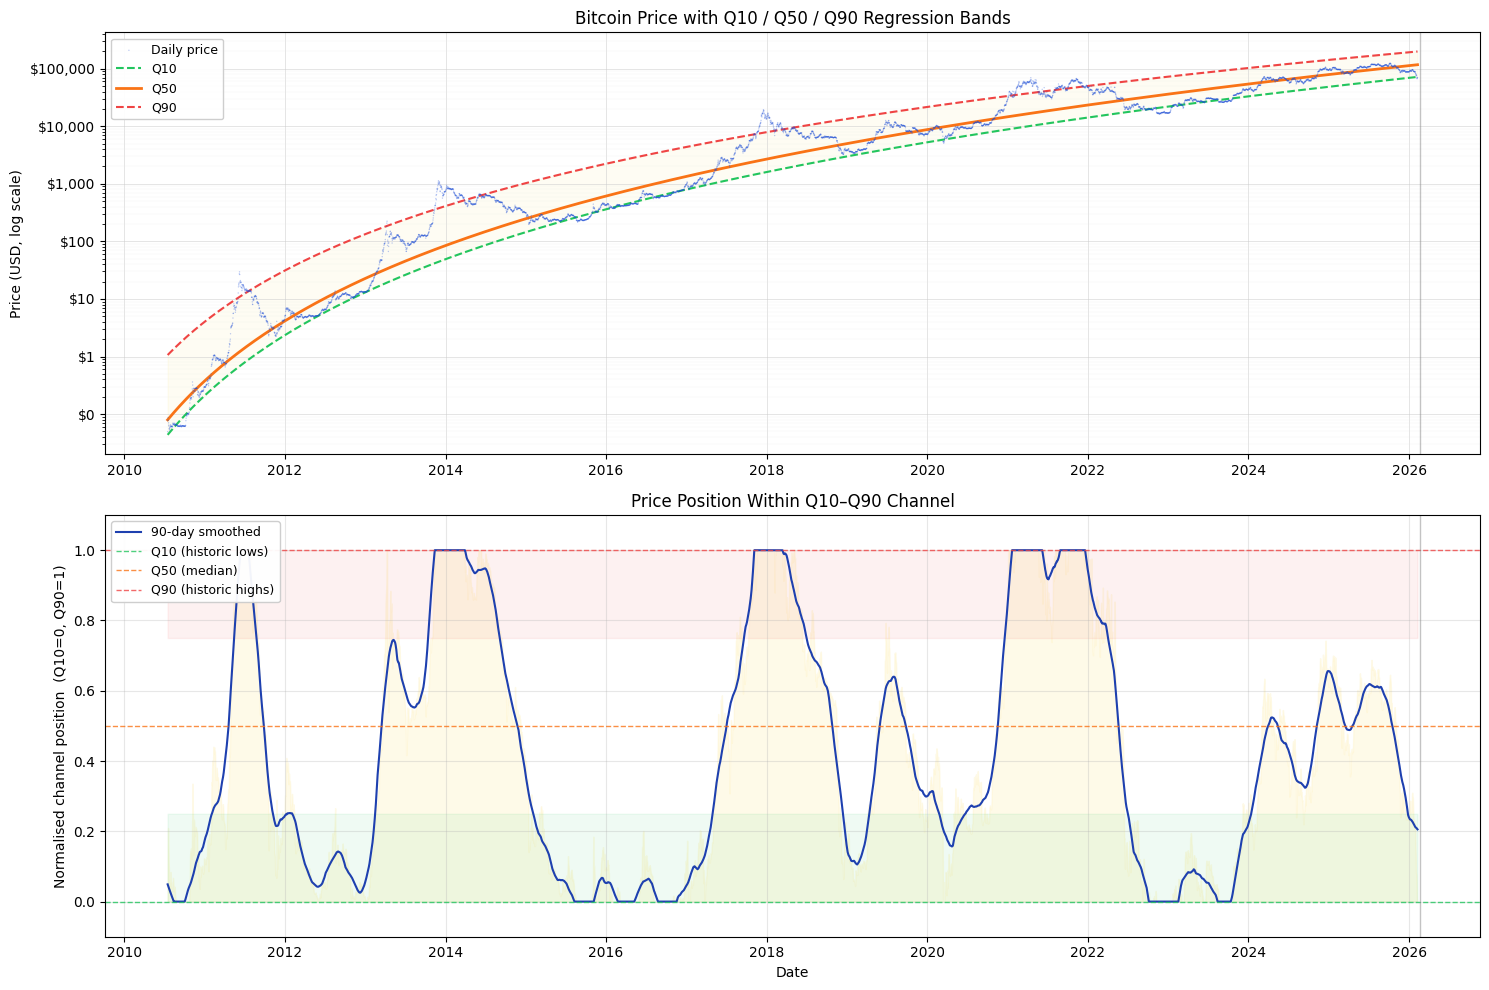

  Saved qr_beta_by_quantile.svg / .jpg


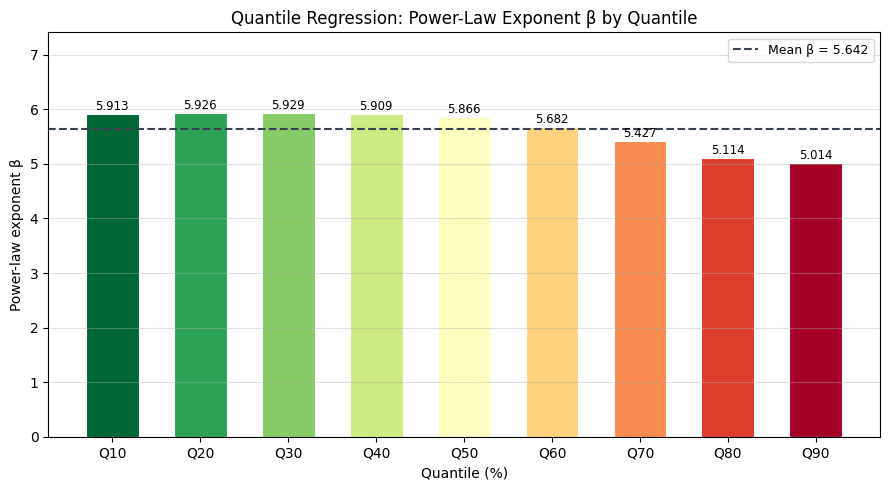


QUANTILE SUMMARY  (evaluated at today's t)
    Quantile           α         β             A    Model price
---------------------------------------------------------------------------
  Q10%            -2.4306    5.9133    3.7100e-03  $      72,875
  Q20%            -2.3902    5.9259    4.0720e-03  $      82,905
  Q30%            -2.3440    5.9288    4.5291e-03  $      92,979
  Q40%            -2.2733    5.9095    5.3301e-03  $     103,567
  Q50%            -2.1614    5.8665    6.8962e-03  $     118,591
  Q60%            -1.8837    5.6824    1.3071e-02  $     133,265
  Q70%            -1.5503    5.4265    2.8166e-02  $     138,861
  Q80%            -1.1318    5.1144    7.3830e-02  $     150,019
  Q90%            -0.8811    5.0141    1.3151e-01  $     200,958

  Actual latest price: $70,377  (2026-02-08)


In [13]:

# ══════════════════════════════════════════════════════════════════════════════
# CELL 1 — Data Loading, Imports & Quantile Regression Analysis
# ══════════════════════════════════════════════════════════════════════════════

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from matplotlib.ticker import FixedLocator, StrMethodFormatter, NullFormatter
import statsmodels.api as sm
from scipy.optimize import differential_evolution
import warnings
warnings.filterwarnings('ignore')

# ── Configuration ──────────────────────────────────────────────────────────────
csv_path  = './BitcoinPricesDaily.csv'
genesis   = pd.to_datetime('2009-01-09')
QUANTILES = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
MIN_YEARS = 1.0   # exclude data within first year of genesis

# ── Load & clean ───────────────────────────────────────────────────────────────
df = pd.read_csv(csv_path)
print(f"Raw columns : {df.columns.tolist()}")
print(f"Shape       : {df.shape}")

df.columns = ['Date', 'Price']                                        # Time → Date, Avg → Price
df['Date']  = pd.to_datetime(df['Date'], format='%m/%d/%y', errors='coerce')
df = df.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df[df['Price'] > 0].copy()

df['years'] = (df['Date'] - genesis).dt.days / 365.25
df = df[df['years'] >= MIN_YEARS].reset_index(drop=True)

df['log_t'] = np.log10(df['years'])
df['log_p'] = np.log10(df['Price'])

print(f"\nDate range  : {df['Date'].min().date()} → {df['Date'].max().date()}")
print(f"Price range : ${df['Price'].min():,.4f} – ${df['Price'].max():,.2f}")
print(f"Points      : {len(df)}")

# ── Quantile regression ────────────────────────────────────────────────────────
print("\n" + "=" * 70)
print("QUANTILE REGRESSION   log₁₀(price) = α + β · log₁₀(years)")
print("=" * 70)

X = sm.add_constant(df['log_t'])
qr_results = {}
for q in QUANTILES:
    res = sm.QuantReg(df['log_p'], X).fit(q=q, max_iter=10_000)
    intercept, slope = res.params
    qr_results[q] = dict(intercept=intercept, slope=slope,
                          A=10**intercept, B=slope)
    print(f"  Q{q:.0%}: price = {10**intercept:.4e} × t^{slope:.4f}   "
          f"(α={intercept:.4f}, β={slope:.4f})")

# ── Where is the most recent data point? ──────────────────────────────────────
today        = pd.Timestamp.today()
today_years  = (today - genesis).days / 365.25
latest_price = df['Price'].iloc[-1]
latest_date  = df['Date'].iloc[-1]

print(f"\nLatest data ({latest_date.date()}):  t = {today_years:.3f} yr,  "
      f"price = ${latest_price:,.0f}")
for q, r in qr_results.items():
    qp = r['A'] * today_years ** r['B']
    print(f"  Q{q:.0%} model = ${qp:,.0f}   → actual is {latest_price/qp:.2f}× the Q{q:.0%} line")

# ── Plot helpers ───────────────────────────────────────────────────────────────
years_plot  = np.linspace(MIN_YEARS, 42.0, 3000)

exponents       = np.arange(-2, 9)
major_positions = 10.0 ** exponents
minor_positions = [sub * 10.0**exp for exp in exponents for sub in range(2, 10)]
every_year      = np.arange(1, 43)

x_tick_values_log   = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 35, 40]
combined_labels_log = [f"{y}\n{2009+y}" for y in x_tick_values_log]

cmap   = plt.cm.RdYlGn_r
colors = {q: cmap(i / (len(QUANTILES) - 1)) for i, q in enumerate(QUANTILES)}

DATA_COLOR = '#1D4ED8'   # blue for price scatter points

def setup_loglog_axes(ax):
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.yaxis.set_major_locator(FixedLocator(major_positions))
    ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
    ax.yaxis.set_minor_locator(FixedLocator(minor_positions))
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks(x_tick_values_log)
    ax.set_xticklabels(combined_labels_log, fontsize=8)
    ax.xaxis.set_minor_locator(FixedLocator(every_year))
    ax.grid(which='major', color='#CCCCCC', lw=0.6, alpha=0.6)
    ax.grid(which='minor', color='#E5E5E5', lw=0.3, alpha=0.4)
    ax.set_facecolor('white')

def save_plot(basename):
    plt.savefig(f'{basename}.svg', format='svg', bbox_inches='tight')
    plt.savefig(f'{basename}.jpg', format='jpg', bbox_inches='tight', dpi=200)
    print(f"  Saved {basename}.svg / .jpg")

# ══════════════════════════════════════════════════════════════════════════════
# PLOT 1 — Log-log with quantile channel bands
# ══════════════════════════════════════════════════════════════════════════════
q_prices = {q: qr_results[q]['A'] * years_plot ** qr_results[q]['B']
            for q in QUANTILES}

fig, ax = plt.subplots(figsize=(15, 9))
setup_loglog_axes(ax)

ax.scatter(df['years'], df['Price'], color=DATA_COLOR, alpha=0.35, s=1.5,
           edgecolor='none', label='Daily price', zorder=3)

for q_lo, q_hi in zip(QUANTILES[:-1], QUANTILES[1:]):
    ax.fill_between(years_plot, q_prices[q_lo], q_prices[q_hi],
                    color=colors[q_hi], alpha=0.12, zorder=2)

for q in QUANTILES:
    lw = 2.0 if q == 0.50 else 1.2
    ls = '-'  if q in (0.10, 0.50, 0.90) else '--'
    ax.plot(years_plot, q_prices[q], color=colors[q], lw=lw, ls=ls,
            label=f'Q{q:.0%}  β={qr_results[q]["B"]:.3f}', zorder=5)

ax.axvline(today_years, color='#888', ls='-', lw=1.0, alpha=0.5, label='Today')
ax.set_ylim(0.01, 1e8); ax.set_xlim(1, 42)
ax.set_xlabel('Years since Bitcoin genesis (Jan 2009)')
ax.set_ylabel('Bitcoin Price (USD)')
ax.set_title('Bitcoin Price — Quantile Regression Channels (log-log)', fontsize=13)
ax.legend(loc='upper left', fontsize=8.5, framealpha=0.95, ncol=2,
          edgecolor='#CCCCCC', facecolor='white')
plt.tight_layout(pad=1.5)
save_plot('qr_loglog_channels')
plt.show()

# ══════════════════════════════════════════════════════════════════════════════
# PLOT 2 — Price vs Q10/Q50/Q90 over calendar time  +  normalised gauge
# ══════════════════════════════════════════════════════════════════════════════
log_q10 = np.log10(qr_results[0.10]['A'] * df['years'] ** qr_results[0.10]['B'])
log_q90 = np.log10(qr_results[0.90]['A'] * df['years'] ** qr_results[0.90]['B'])
norm_pos    = (df['log_p'] - log_q10) / (log_q90 - log_q10)
norm_smooth = pd.Series(norm_pos.values).rolling(90, center=True, min_periods=30).mean()

q10_line = qr_results[0.10]['A'] * df['years'] ** qr_results[0.10]['B']
q50_line = qr_results[0.50]['A'] * df['years'] ** qr_results[0.50]['B']
q90_line = qr_results[0.90]['A'] * df['years'] ** qr_results[0.90]['B']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1.set_yscale('log')
ax1.scatter(df['Date'], df['Price'], color=DATA_COLOR, alpha=0.3, s=1,
            edgecolor='none', zorder=3, label='Daily price')
ax1.plot(df['Date'], q10_line, color='#22C55E', lw=1.5, ls='--', label='Q10')
ax1.plot(df['Date'], q50_line, color='#F97316', lw=2.0, ls='-',  label='Q50')
ax1.plot(df['Date'], q90_line, color='#EF4444', lw=1.5, ls='--', label='Q90')
ax1.fill_between(df['Date'], q10_line, q90_line, color='#FDE68A', alpha=0.10)
ax1.yaxis.set_major_locator(FixedLocator(major_positions))
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax1.yaxis.set_minor_locator(FixedLocator(minor_positions))
ax1.grid(which='major', color='#CCCCCC', lw=0.6, alpha=0.6)
ax1.grid(which='minor', color='#E5E5E5', lw=0.3, alpha=0.4)
ax1.set_facecolor('white')
ax1.axvline(today, color='#888', ls='-', lw=1.0, alpha=0.5)
ax1.set_title('Bitcoin Price with Q10 / Q50 / Q90 Regression Bands')
ax1.set_ylabel('Price (USD, log scale)')
ax1.legend(loc='upper left', fontsize=9, framealpha=0.95)

ax2.fill_between(df['Date'], 0, norm_pos.clip(0, 1), color='#FEF3C7', alpha=0.4)
ax2.plot(df['Date'], norm_smooth.clip(0, 1), color='#1E40AF', lw=1.5,
         label='90-day smoothed')
ax2.axhline(0.0, color='#22C55E', ls='--', lw=1, alpha=0.8, label='Q10 (historic lows)')
ax2.axhline(0.5, color='#F97316', ls='--', lw=1, alpha=0.8, label='Q50 (median)')
ax2.axhline(1.0, color='#EF4444', ls='--', lw=1, alpha=0.8, label='Q90 (historic highs)')
ax2.fill_between(df['Date'], 0, 0.25,  color='#22C55E', alpha=0.07)
ax2.fill_between(df['Date'], 0.75, 1.0, color='#EF4444', alpha=0.07)
ax2.axvline(today, color='#888', ls='-', lw=1.0, alpha=0.5)
ax2.set_ylim(-0.1, 1.1)
ax2.set_ylabel('Normalised channel position  (Q10=0, Q90=1)')
ax2.set_xlabel('Date')
ax2.set_title('Price Position Within Q10–Q90 Channel')
ax2.legend(loc='upper left', fontsize=9, framealpha=0.95)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
save_plot('qr_normalized_position')
plt.show()

# ══════════════════════════════════════════════════════════════════════════════
# PLOT 3 — Power-law exponent β across quantiles
# ══════════════════════════════════════════════════════════════════════════════
betas      = [qr_results[q]['B'] for q in QUANTILES]
qs_pct     = [q * 100 for q in QUANTILES]
bar_colors = [colors[q] for q in QUANTILES]

fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.bar(qs_pct, betas, width=6, color=bar_colors, edgecolor='white', lw=0.8)
ax.axhline(np.mean(betas), color='#374151', ls='--', lw=1.5,
           label=f'Mean β = {np.mean(betas):.3f}')
for bar, b in zip(bars, betas):
    ax.text(bar.get_x() + bar.get_width()/2, b + 0.02, f'{b:.3f}',
            ha='center', va='bottom', fontsize=8.5)
ax.set_xlabel('Quantile (%)')
ax.set_ylabel('Power-law exponent β')
ax.set_title('Quantile Regression: Power-Law Exponent β by Quantile')
ax.set_xticks(qs_pct)
ax.set_xticklabels([f'Q{int(q)}' for q in qs_pct])
ax.set_ylim(0, max(betas) * 1.25)
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.4)
ax.set_facecolor('white')
plt.tight_layout()
save_plot('qr_beta_by_quantile')
plt.show()

# ── Summary table ──────────────────────────────────────────────────────────────
print("\n" + "=" * 75)
print("QUANTILE SUMMARY  (evaluated at today's t)")
print("=" * 75)
print(f"  {'Quantile':>10}  {'α':>10}  {'β':>8}  {'A':>12}  {'Model price':>13}")
print("-" * 75)
for q in QUANTILES:
    r  = qr_results[q]
    mp = r['A'] * today_years ** r['B']
    print(f"  Q{q:.0%}         {r['intercept']:>10.4f}  {r['B']:>8.4f}  "
          f"{r['A']:>12.4e}  ${mp:>12,.0f}")
print(f"\n  Actual latest price: ${latest_price:,.0f}  ({latest_date.date()})")
print("=" * 75)


CSV loaded successfully!
Shape: (5686, 2)

Date range: 2010-07 to 2026-02
Valid points: 5686
Price range: $0.05 – $124,641.52

Fit date range: from 2010-01-01 (5686 points)

STEP 1: FITTING SUPPORT LINE (bottom 29% of data)
  OLS residual cutoff: -0.2172
  Support points: 1649 / 5686
  Support power law: price = 4.9089e-03 × t^5.7988

STEP 2: DETECTING BUBBLE REGIONS
  Threshold: 0.220 log₁₀ (1.7× support)
  Initial regions detected: 5
    SYNTHETIC: Inserted near 2014-10-14
  After gap enforcement: 5 regions

  FINAL: 5 bubble regions:
    Bubble 1: 2011-04-09 – 2011-10-26  (200d)  peak: 2011-06-09  excess: 1.562 (36.5×)
    Bubble 2: 2013-02-23 – 2015-01-09  (685d)  peak: 2013-11-30  excess: 1.365 (23.2×)
    Bubble 3: 2017-05-15 – 2019-11-17  (916d)  peak: 2017-12-17  excess: 1.081 (12.0×)
    Bubble 4: 2020-10-30 – 2022-06-04  (582d)  peak: 2021-04-16  excess: 0.839 (6.9×)
    Bubble 5: 2024-02-26 – 2025-11-06  (619d)  peak: 2024-12-17  excess: 0.364 (2.3×)

STEP 3: FITTING BUBBLE 

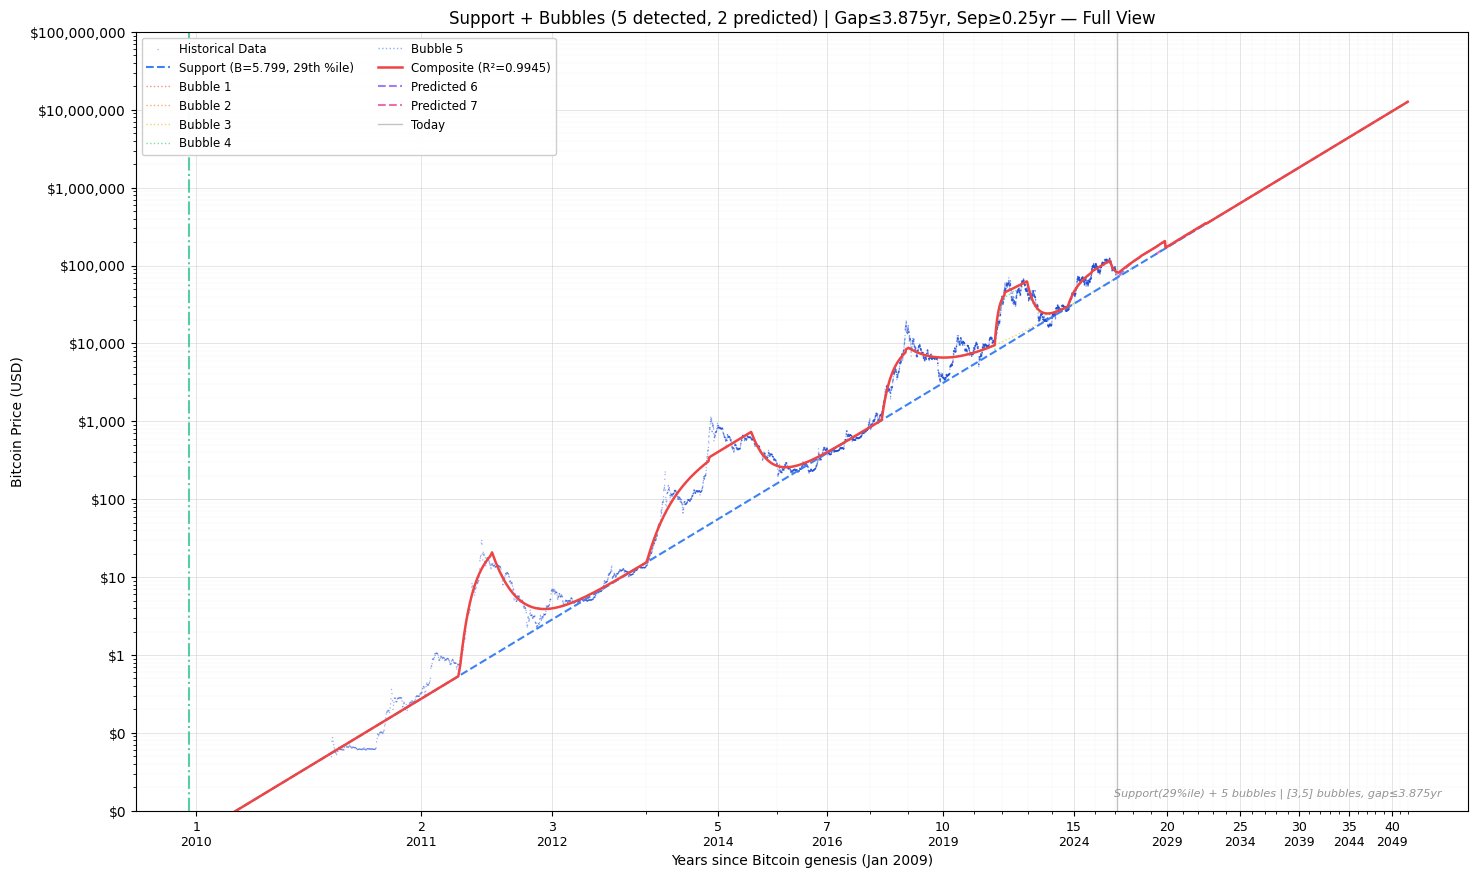

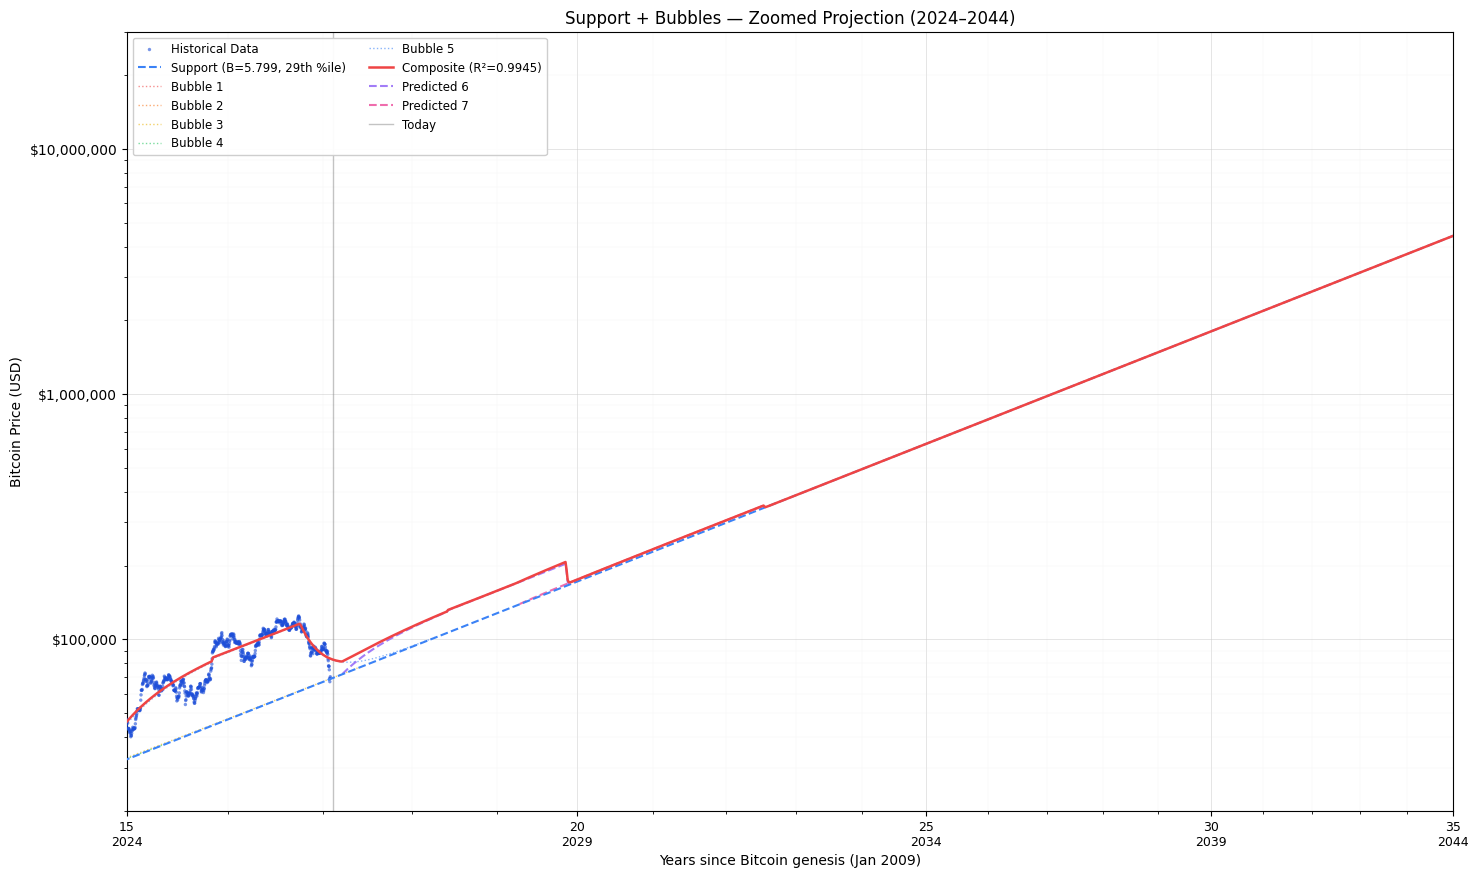

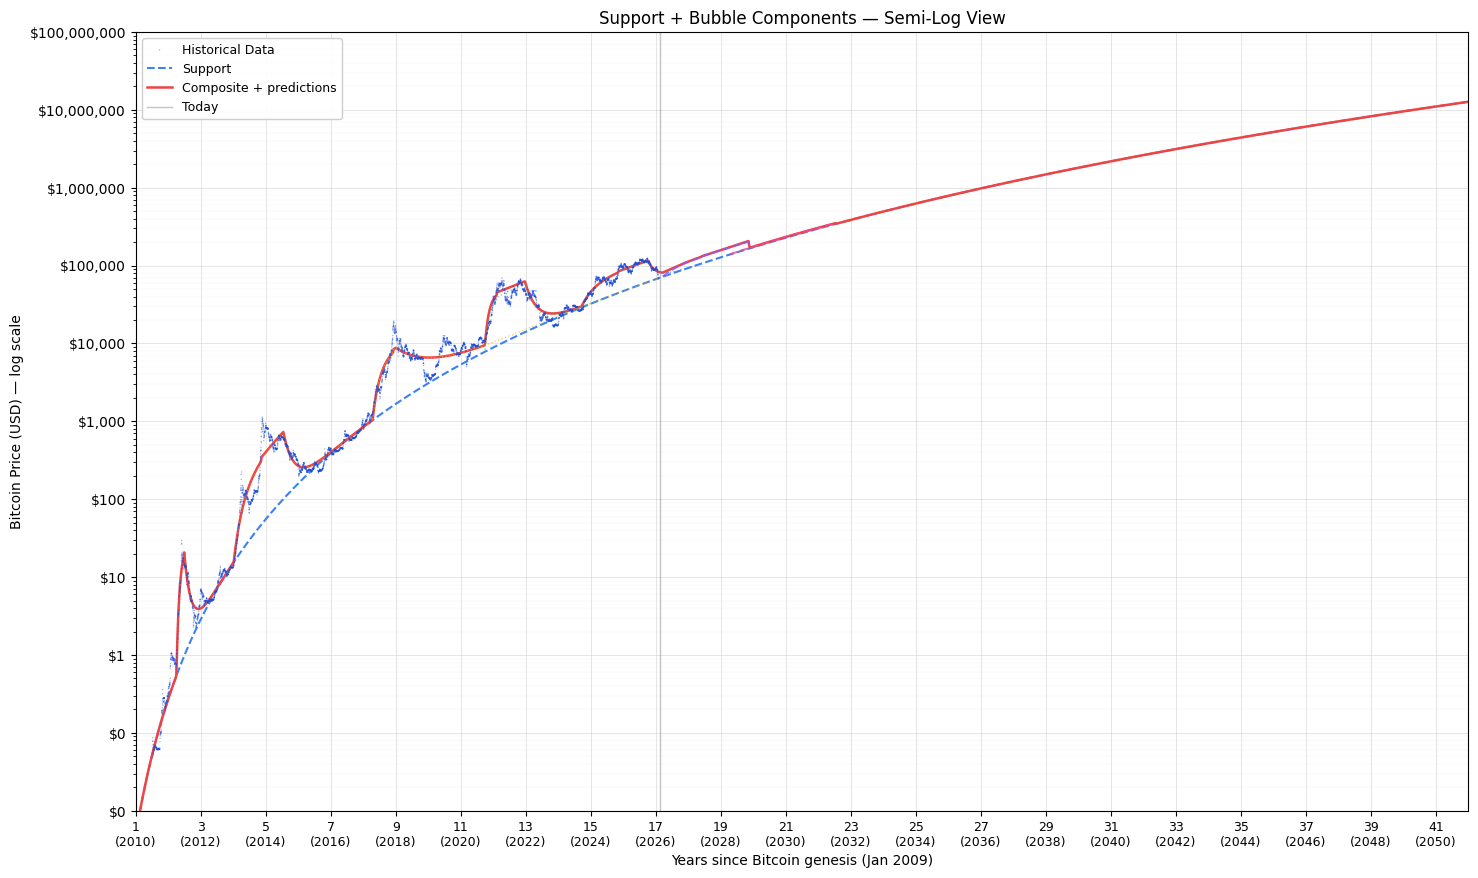

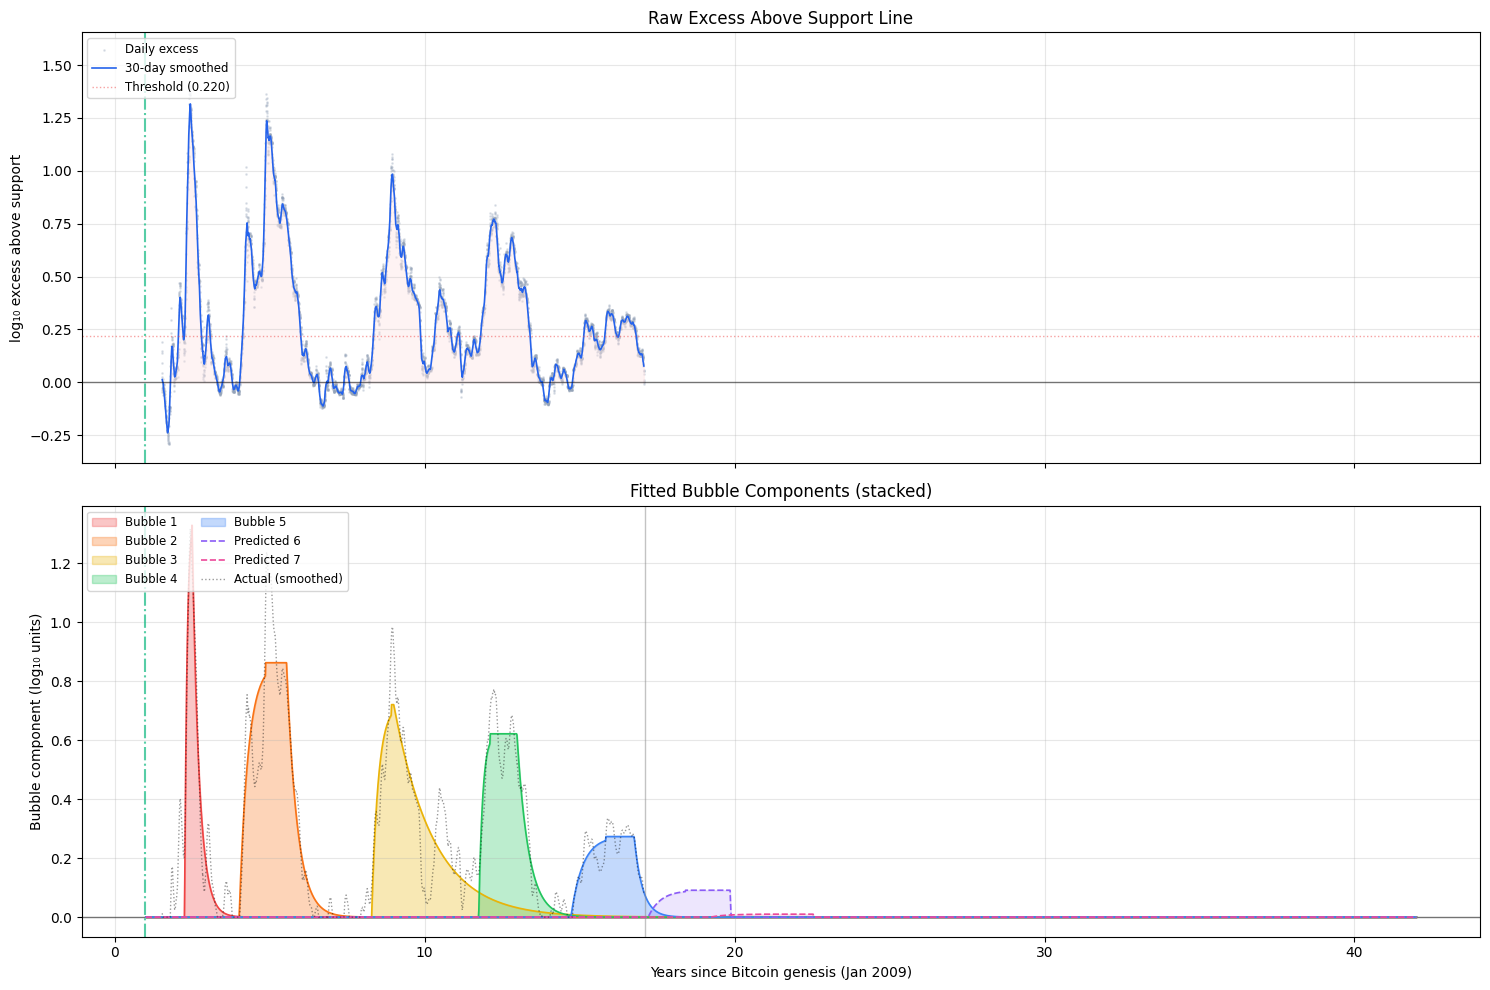

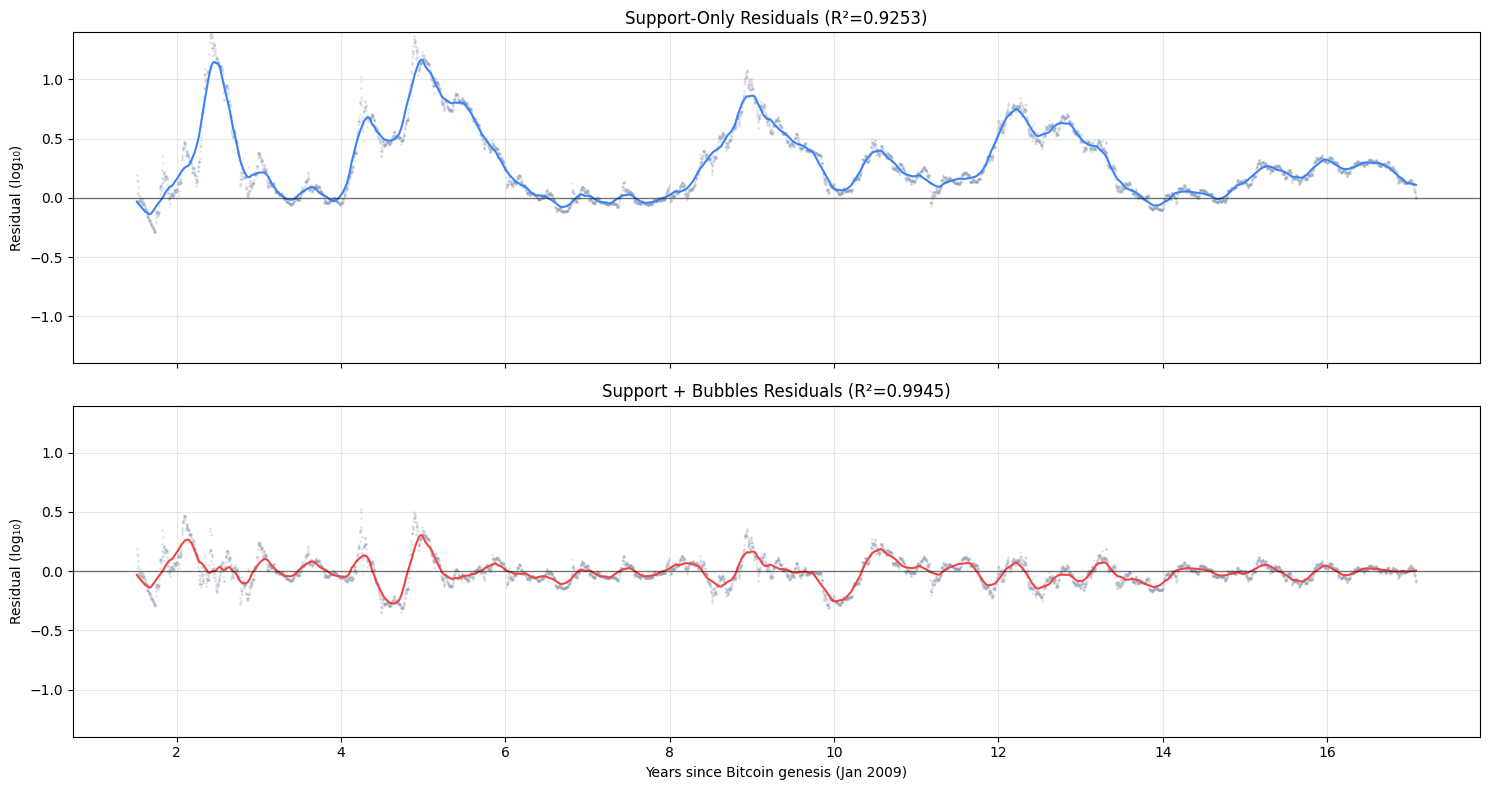


FINAL MODEL SUMMARY

  SUPPORT:  price = 4.9089e-03 × t^5.7988
  (τ=0.5 quantile of bottom 29% by OLS residual)

  CONSTRAINTS:  bubbles [3,5]  gap≤3.875yr  sep≥0.25yr  threshold=0.220

  DETECTED: 5   PREDICTED: 2
  EXTRAPOLATION: weighted linear trend  (custom weights (5×5=25 entries))
  WEIGHTS LAYOUT: [tau_rise, tau_fall, plateau, interval, scale] × 5 bubbles

  R² composite: 0.994495   R² support: 0.925263


In [20]:

# ══════════════════════════════════════════════════════════════════════════════
# SUPPORT + BUBBLE COMPONENTS MODEL v3 — Bitcoin Price
# ══════════════════════════════════════════════════════════════════════════════

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from scipy.stats import linregress
from matplotlib.ticker import FixedLocator, StrMethodFormatter, NullFormatter
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# ── CONFIGURATION ─────────────────────────────────────────────────────────────
csv_path = './BitcoinPricesDaily.csv'

DATA_COLOR = '#1D4ED8'   # colour for price scatter points

SUPPORT_PERCENTILE = 29
SUPPORT_QUANTILE   = 0.50

BUBBLE_THRESHOLD        = 0.22
BUBBLE_MIN_DURATION     = 60
BUBBLE_MERGE_GAP        = 180
SMOOTHING_WINDOW        = 30

MIN_BUBBLES             = 3
MAX_BUBBLES             = 5
MAX_BUBBLE_GAP          = 3.875
MIN_INTERBUBBLE_PERIOD  = 0.25

DE_MAXITER = 3000
DE_POPSIZE = 20

FIT_MIN_DATE     = '2010-01-01'
FIT_MAX_DATE     = None

N_FUTURE_BUBBLES = 2

# ── BUBBLE EXTRAPOLATION WEIGHTS ──────────────────────────────────────────────
# Flat array of (N_detected_bubbles × 5) floats.
# Each future bubble's parameters are produced by fitting a weighted linear
# trend across all detected bubbles and extrapolating forward.
#
# 5 weights per bubble, in order:
#   [ tau_rise,  tau_fall,  plateau,  interval,  scale ]
#       idx 0      idx 1     idx 2      idx 3     idx 4
#
# Layout for 4 detected bubbles (4 × 5 = 20 entries):
#   BUBBLE_EXTRAP_WEIGHTS = [
#       w1_rise, w1_fall, w1_plat, w1_intv, w1_scale,   # bubble 1
#       w2_rise, w2_fall, w2_plat, w2_intv, w2_scale,   # bubble 2
#       w3_rise, w3_fall, w3_plat, w3_intv, w3_scale,   # bubble 3
#       w4_rise, w4_fall, w4_plat, w4_intv, w4_scale,   # bubble 4
#   ]
#
# Weights are passed directly to np.polyfit as the 'w' argument (larger =
# more influence on the trend line).  Set to None for uniform weights.
#
# Note: interval[i] = gap(bubble i → bubble i+1) uses w[i, 3].
# The last bubble has no outgoing interval, so its interval weight is unused
# in the fit but still occupies a slot in the array.
#
# Example — down-weight the oldest bubble, emphasise recent ones:
BUBBLE_EXTRAP_WEIGHTS = [0.0, 0.0, 0.0, 0.0, 0.0,
                          0.0, 0.0, 0.0, 0.0, 0.0,
                          1.0, 1.0, 1.0, 1.0, 1.0,
                          1.0, 1.0, 1.0, 1.0, 1.0,
                          1.0, 1.0, 1.0, 1.0, 1.0]
#BUBBLE_EXTRAP_WEIGHTS = None

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

# ── Load and clean data ──────────────────────────────────────────────────────
try:
    df = pd.read_csv(csv_path)
    print("CSV loaded successfully!")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print(f"File not found: {csv_path}")
except Exception as e:
    print("Error loading CSV:", str(e))

df.columns = ['Date', 'Price']   # CSV columns are 'Time' and 'Avg'

date_column  = 'Date'
value_column = 'Price'

df[date_column] = pd.to_datetime(df[date_column], format='%m/%d/%y', errors='coerce')
df = df.dropna(subset=[date_column])
df = df.sort_values(date_column)

x_dates = df[date_column]
y_data  = df[value_column].astype(float)

print(f"\nDate range: {x_dates.min().strftime('%Y-%m')} to {x_dates.max().strftime('%Y-%m')}")
print(f"Valid points: {len(y_data)}")
print(f"Price range: ${y_data.min():,.2f} – ${y_data.max():,.2f}")

# ── Prepare data ─────────────────────────────────────────────────────────────
valid         = y_data > 0
y_valid       = y_data[valid]
x_dates_valid = x_dates[valid]

genesis      = pd.to_datetime('2009-01-09')
years_since  = (x_dates_valid - genesis).dt.days / 365.25
years_valid  = years_since.astype(float)

MIN_YEARS  = 1.0
reasonable = years_valid >= MIN_YEARS
years_all  = years_valid[reasonable].values
y_all      = y_valid[reasonable].values
dates_all  = x_dates_valid[reasonable].values

log_t_all = np.log10(years_all)
log_p_all = np.log10(y_all)

# ── Date masks ───────────────────────────────────────────────────────────────
fit_mask = np.ones(len(dates_all), dtype=bool)
if FIT_MIN_DATE is not None:
    fit_mask &= pd.to_datetime(dates_all) >= pd.to_datetime(FIT_MIN_DATE)
if FIT_MAX_DATE is not None:
    fit_mask &= pd.to_datetime(dates_all) <= pd.to_datetime(FIT_MAX_DATE)

log_t      = log_t_all[fit_mask]
log_p      = log_p_all[fit_mask]
years_fit  = years_all[fit_mask]
dates_fit  = dates_all[fit_mask]

date_desc = "all data"
if FIT_MIN_DATE and FIT_MAX_DATE:
    date_desc = f"{FIT_MIN_DATE} to {FIT_MAX_DATE}"
elif FIT_MIN_DATE:
    date_desc = f"from {FIT_MIN_DATE}"
elif FIT_MAX_DATE:
    date_desc = f"up to {FIT_MAX_DATE}"
print(f"\nFit date range: {date_desc} ({len(log_t)} points)")

fit_min_years = (pd.to_datetime(FIT_MIN_DATE) - genesis).days / 365.25 if FIT_MIN_DATE else None
fit_max_years = (pd.to_datetime(FIT_MAX_DATE) - genesis).days / 365.25 if FIT_MAX_DATE else None
today_years   = (pd.to_datetime('today') - genesis).days / 365.25

# ══════════════════════════════════════════════════════════════════════════════
# STEP 1: FIT SUPPORT LINE
# ══════════════════════════════════════════════════════════════════════════════
print("\n" + "=" * 80)
print(f"STEP 1: FITTING SUPPORT LINE (bottom {SUPPORT_PERCENTILE}% of data)")
print("=" * 80)

slope_ols, intercept_ols, r_ols, _, _ = linregress(log_t, log_p)
ols_resid = log_p - (intercept_ols + slope_ols * log_t)
cutoff    = np.percentile(ols_resid, SUPPORT_PERCENTILE)

support_mask   = ols_resid <= cutoff
log_t_support  = log_t[support_mask]
log_p_support  = log_p[support_mask]

print(f"  OLS residual cutoff: {cutoff:+.4f}")
print(f"  Support points: {np.sum(support_mask)} / {len(log_t)}")

X_support      = sm.add_constant(log_t_support)
model_support  = sm.QuantReg(log_p_support, X_support)
result_support = model_support.fit(q=SUPPORT_QUANTILE, max_iter=10000)

intercept_sup = result_support.params[0]
slope_sup     = result_support.params[1]
A_sup         = 10 ** intercept_sup
B_sup         = slope_sup

print(f"  Support power law: price = {A_sup:.4e} × t^{B_sup:.4f}")

log_support_all = intercept_sup + slope_sup * log_t_all
support_all     = 10 ** log_support_all
log_support_fit = intercept_sup + slope_sup * log_t
support_fit     = 10 ** log_support_fit

# ══════════════════════════════════════════════════════════════════════════════
# STEP 2: DETECT BUBBLE REGIONS
# ══════════════════════════════════════════════════════════════════════════════
print("\n" + "=" * 80)
print("STEP 2: DETECTING BUBBLE REGIONS")
print("=" * 80)

log_excess_all = log_p_all - log_support_all
log_excess_fit = log_p    - log_support_fit

excess_smooth = pd.Series(log_excess_fit).rolling(
    window=SMOOTHING_WINDOW, center=True, min_periods=20).mean().values


def detect_regions(threshold):
    above = excess_smooth > threshold
    above[np.isnan(excess_smooth)] = False
    regs, in_region = [], False
    for i in range(len(above)):
        if above[i] and not in_region:
            region_start, in_region = i, True
        elif not above[i] and in_region:
            regs.append((region_start, i - 1))
            in_region = False
    if in_region:
        regs.append((region_start, len(above) - 1))
    regs = [(s, e) for s, e in regs
            if (years_fit[e] - years_fit[s]) * 365.25 >= BUBBLE_MIN_DURATION]
    merged = []
    for s, e in regs:
        if merged and (years_fit[s] - years_fit[merged[-1][1]]) * 365.25 < BUBBLE_MERGE_GAP:
            merged[-1] = (merged[-1][0], e)
        else:
            merged.append((s, e))
    return merged


current_threshold = BUBBLE_THRESHOLD
regions  = detect_regions(current_threshold)
attempts = 0
while len(regions) < MIN_BUBBLES and current_threshold > 0.02:
    current_threshold *= 0.8
    regions  = detect_regions(current_threshold)
    attempts += 1

if attempts > 0:
    print(f"  Threshold auto-lowered: {BUBBLE_THRESHOLD:.3f} → {current_threshold:.3f} "
          f"({attempts} steps)")
else:
    print(f"  Threshold: {current_threshold:.3f} log₁₀ ({10**current_threshold:.1f}× support)")
print(f"  Initial regions detected: {len(regions)}")

if MAX_BUBBLE_GAP is not None and len(regions) > 0:
    region_starts = [years_fit[s] for s, e in regions]
    data_start    = years_fit[0]
    gaps_to_fill  = []
    if region_starts[0] - data_start > MAX_BUBBLE_GAP:
        t_cursor = data_start + MAX_BUBBLE_GAP / 2
        while t_cursor < region_starts[0] - MAX_BUBBLE_GAP / 2:
            gaps_to_fill.append(t_cursor)
            t_cursor += MAX_BUBBLE_GAP
    for i in range(len(region_starts) - 1):
        gap = region_starts[i + 1] - region_starts[i]
        if gap > MAX_BUBBLE_GAP:
            n_missing = int(np.ceil(gap / MAX_BUBBLE_GAP)) - 1
            for j in range(1, n_missing + 1):
                gaps_to_fill.append(region_starts[i] + j * gap / (n_missing + 1))
    synthetic_regions = []
    for fill_t in gaps_to_fill:
        s0 = max(0, np.argmin(np.abs(years_fit - (fill_t - 0.5))))
        s1 = min(len(years_fit) - 1, np.argmin(np.abs(years_fit - (fill_t + 0.5))))
        if s1 > s0:
            lp  = s0 + np.argmax(log_excess_fit[s0:s1+1])
            hw  = max(30, int(BUBBLE_MIN_DURATION / 2))
            synthetic_regions.append((max(0, lp - hw), min(len(years_fit)-1, lp + hw)))
            print(f"    SYNTHETIC: Inserted near {pd.Timestamp(dates_fit[lp]).strftime('%Y-%m-%d')}")
    all_regions = sorted(regions + synthetic_regions, key=lambda x: x[0])
    merged_final = []
    for s, e in all_regions:
        if merged_final and years_fit[s] - years_fit[merged_final[-1][1]] < BUBBLE_MERGE_GAP / 365.25:
            merged_final[-1] = (merged_final[-1][0], max(merged_final[-1][1], e))
        else:
            merged_final.append((s, e))
    regions = merged_final
    print(f"  After gap enforcement: {len(regions)} regions")

if MIN_INTERBUBBLE_PERIOD is not None and len(regions) > 1:
    filtered, dropped_count = [regions[0]], 0
    for i in range(1, len(regions)):
        if years_fit[regions[i][0]] - years_fit[filtered[-1][0]] >= MIN_INTERBUBBLE_PERIOD:
            filtered.append(regions[i])
        else:
            dropped_count += 1
    if dropped_count:
        print(f"  Dropped {dropped_count} regions too close (< {MIN_INTERBUBBLE_PERIOD} yr)")
    regions = filtered

if MAX_BUBBLES is not None and len(regions) > MAX_BUBBLES:
    scored = sorted([(np.max(log_excess_fit[s:e+1]), s, e) for s, e in regions], reverse=True)
    regions = sorted([(s, e) for _, s, e in scored[:MAX_BUBBLES]], key=lambda x: x[0])
    print(f"  Trimmed to {MAX_BUBBLES} largest bubbles")

print(f"\n  FINAL: {len(regions)} bubble regions:")
for i, (s, e) in enumerate(regions):
    d_s = pd.Timestamp(dates_fit[s]); d_e = pd.Timestamp(dates_fit[e])
    pi  = s + np.argmax(log_excess_fit[s:e+1])
    pv  = log_excess_fit[pi]
    dp  = pd.Timestamp(dates_fit[pi])
    print(f"    Bubble {i+1}: {d_s.strftime('%Y-%m-%d')} – {d_e.strftime('%Y-%m-%d')}  "
          f"({(d_e-d_s).days}d)  peak: {dp.strftime('%Y-%m-%d')}  "
          f"excess: {pv:.3f} ({10**pv:.1f}×)")

# ══════════════════════════════════════════════════════════════════════════════
# STEP 3: FIT INDIVIDUAL BUBBLE COMPONENTS
# ══════════════════════════════════════════════════════════════════════════════
print("\n" + "=" * 80)
print("STEP 3: FITTING BUBBLE COMPONENTS")
print("=" * 80)


def bubble_shape(t, t_start, tau_rise, t_plateau_dur, tau_fall, scale):
    result       = np.zeros_like(t, dtype=float)
    t_rise_end   = t_start + 3.0 * tau_rise
    t_fall_start = t_rise_end + t_plateau_dur
    rising       = (t >= t_start) & (t < t_rise_end)
    result[rising]  = scale * (1 - np.exp(-(t[rising] - t_start) / tau_rise))
    plateau         = (t >= t_rise_end) & (t < t_fall_start)
    result[plateau] = scale
    falling         = t >= t_fall_start
    result[falling] = scale * np.exp(-(t[falling] - t_fall_start) / tau_fall)
    return np.maximum(result, 0)


def fit_single_bubble(region_idx, s, e):
    context_years   = 1.0
    t_region_start  = years_fit[s]
    t_region_end    = years_fit[e]
    t_context_start = max(years_fit[0],  t_region_start - context_years)
    t_context_end   = min(years_fit[-1], t_region_end   + context_years)
    ctx_mask = (years_fit >= t_context_start) & (years_fit <= t_context_end)
    t_ctx    = years_fit[ctx_mask]
    exc_ctx  = np.maximum(0, log_excess_fit[ctx_mask])
    bounds   = [(t_region_start - context_years, t_region_start + 0.3),
                (0.05, 2.0), (0.0, 1.5), (0.05, 2.0), (0.01, 3.0)]
    def objective(p):
        return np.sum((exc_ctx - bubble_shape(t_ctx, *p)) ** 2)
    res = differential_evolution(objective, bounds,
                                 maxiter=DE_MAXITER, popsize=DE_POPSIZE,
                                 seed=42 + region_idx, tol=1e-10, polish=True)
    return res.x, res.fun


bubble_params = []
for i, (s, e) in enumerate(regions):
    params, cost = fit_single_bubble(i, s, e)
    t_start, tau_rise, t_plateau_dur, tau_fall, scale = params
    t_rise_end     = t_start + 3.0 * tau_rise
    t_fall_start   = t_rise_end + t_plateau_dur
    total_duration = (t_fall_start + 3.0 * tau_fall) - t_start
    d_start        = genesis + pd.Timedelta(days=t_start * 365.25)
    d_peak_approx  = genesis + pd.Timedelta(days=t_rise_end * 365.25)
    bubble_params.append({'t_start': t_start, 'tau_rise': tau_rise,
                          't_plateau_dur': t_plateau_dur, 'tau_fall': tau_fall,
                          'scale': scale, 'cost': cost,
                          'date_start': d_start, 'date_peak': d_peak_approx,
                          'total_duration': total_duration})
    print(f"\n  Bubble {i+1}:")
    print(f"    Start:    t={t_start:.3f} yr  ({d_start.strftime('%Y-%m-%d')})")
    print(f"    τ_rise:   {tau_rise:.4f} yr  ({tau_rise*365.25:.0f} days)")
    print(f"    Plateau:  {t_plateau_dur:.4f} yr  ({t_plateau_dur*365.25:.0f} days)")
    print(f"    τ_fall:   {tau_fall:.4f} yr  ({tau_fall*365.25:.0f} days)")
    print(f"    Scale:    {scale:.4f} log₁₀  ({10**scale:.1f}× support)")
    print(f"    Duration: {total_duration:.2f} yr")

# ══════════════════════════════════════════════════════════════════════════════
# STEP 4: COMPOSITE MODEL + R²
# ══════════════════════════════════════════════════════════════════════════════
years_plot  = np.linspace(1.0, 42.0, 3000)
log_t_plot  = np.log10(years_plot)

log_support_plot = intercept_sup + slope_sup * log_t_plot
support_plot     = 10 ** log_support_plot

total_bubble_plot       = np.zeros_like(years_plot)
individual_bubbles_plot = []
for bp in bubble_params:
    bub = bubble_shape(years_plot, bp['t_start'], bp['tau_rise'],
                       bp['t_plateau_dur'], bp['tau_fall'], bp['scale'])
    individual_bubbles_plot.append(bub)
    total_bubble_plot += bub

composite_plot = 10 ** (log_support_plot + total_bubble_plot)

total_bubble_all = np.zeros(len(years_all))
for bp in bubble_params:
    total_bubble_all += bubble_shape(years_all, bp['t_start'], bp['tau_rise'],
                                     bp['t_plateau_dur'], bp['tau_fall'], bp['scale'])
composite_pred_all = log_support_all + total_bubble_all
ss_tot       = np.sum((log_p_all - np.mean(log_p_all)) ** 2)
r2_composite = 1 - np.sum((log_p_all - composite_pred_all) ** 2) / ss_tot
r2_support   = 1 - np.sum((log_p_all - log_support_all)    ** 2) / ss_tot

print(f"\n\n{'='*80}\nMODEL FIT QUALITY\n{'='*80}")
print(f"  R² (support only):      {r2_support:.6f}")
print(f"  R² (support + bubbles): {r2_composite:.6f}")
print(f"  ΔR²:                    {r2_composite - r2_support:.6f}")

# ══════════════════════════════════════════════════════════════════════════════
# STEP 5: BUBBLE PARAMETER TABLE
# ══════════════════════════════════════════════════════════════════════════════
print(f"\n{'='*120}\nBUBBLE PARAMETER TABLE\n{'='*120}")
print(f"  {'#':>3}  {'Start Date':>12}  {'t_start':>8}  {'τ_rise':>8}  {'Plateau':>8}  "
      f"{'τ_fall':>8}  {'Scale':>7}  {'Peak ×':>7}  {'Duration':>9}  {'Δt_start':>9}")
print("-" * 120)
for i, bp in enumerate(bubble_params):
    dt_str = f"{bp['t_start'] - bubble_params[i-1]['t_start']:.2f} yr" if i > 0 else ""
    print(f"  {i+1:>3}  {bp['date_start'].strftime('%Y-%m-%d'):>12}  "
          f"{bp['t_start']:>8.3f}  {bp['tau_rise']:>8.4f}  {bp['t_plateau_dur']:>8.4f}  "
          f"{bp['tau_fall']:>8.4f}  {bp['scale']:>7.3f}  {10**bp['scale']:>7.1f}×  "
          f"{bp['total_duration']:>8.2f}yr  {dt_str:>9}")

if len(bubble_params) >= 2:
    starts        = [bp['t_start'] for bp in bubble_params]
    intervals     = [starts[i+1] - starts[i] for i in range(len(starts)-1)]
    log_starts    = [np.log10(s) for s in starts if s > 0]
    log_intervals = [log_starts[i+1] - log_starts[i] for i in range(len(log_starts)-1)]
    print(f"\n  INTER-BUBBLE TIMING:")
    print(f"    Linear intervals: {['%.2f' % d for d in intervals]}")
    if log_intervals:
        print(f"    Log₁₀ intervals:  {['%.4f' % d for d in log_intervals]}")
    if len(intervals) > 1:
        print(f"    Mean linear: {np.mean(intervals):.2f} yr   CV: {np.std(intervals)/np.mean(intervals):.3f}")
    print(f"\n  PARAMETER TRENDS:")
    print(f"    τ_rise:  {['%.3f' % bp['tau_rise']       for bp in bubble_params]}")
    print(f"    τ_fall:  {['%.3f' % bp['tau_fall']       for bp in bubble_params]}")
    print(f"    Scale:   {['%.3f' % bp['scale']          for bp in bubble_params]}")
    print(f"    Plateau: {['%.3f' % bp['t_plateau_dur']  for bp in bubble_params]}")

# ══════════════════════════════════════════════════════════════════════════════
# STEP 6: PREDICT FUTURE BUBBLES — weighted linear extrapolation
# ══════════════════════════════════════════════════════════════════════════════
print(f"\n{'='*80}")
print(f"STEP 6: PREDICTING NEXT {N_FUTURE_BUBBLES} BUBBLES")
print(f"{'='*80}")

future_bubbles = []

if len(bubble_params) >= 2:
    starts    = [bp['t_start'] for bp in bubble_params]
    intervals = [starts[i+1] - starts[i] for i in range(len(starts)-1)]
    n_bub     = len(bubble_params)

    # ── Weights setup ────────────────────────────────────────────────────────
    # Layout per bubble: [tau_rise, tau_fall, plateau, interval, scale]
    n_params   = 5
    expected_w = n_bub * n_params

    use_custom_weights = (BUBBLE_EXTRAP_WEIGHTS is not None
                          and len(BUBBLE_EXTRAP_WEIGHTS) == expected_w)

    if BUBBLE_EXTRAP_WEIGHTS is not None and not use_custom_weights:
        print(f"  ⚠  BUBBLE_EXTRAP_WEIGHTS length mismatch: "
              f"expected {expected_w} ({n_bub} bubbles × {n_params} params), "
              f"got {len(BUBBLE_EXTRAP_WEIGHTS)}. Using uniform weights.")

    w = (np.array(BUBBLE_EXTRAP_WEIGHTS, dtype=float).reshape(n_bub, n_params)
         if use_custom_weights else np.ones((n_bub, n_params)))

    mode_str = (f"custom weights ({n_bub}×{n_params}={expected_w} entries)"
                if use_custom_weights else "uniform weights")
    print(f"  Extrapolation mode: {mode_str}")

    # ── Weighted linear extrapolation helper ─────────────────────────────────
    def weighted_extrap(values, weights, target_idx):
        """
        Fit a weighted linear trend to (0..N-1, values) and evaluate at
        target_idx.  Falls back to the last value if fewer than 2 points.
        Returns (predicted_value, (slope, intercept)).
        """
        x = np.arange(len(values), dtype=float)
        if len(values) >= 2:
            coeffs = np.polyfit(x, values, 1, w=weights)
        else:
            coeffs = np.array([0.0, float(values[0])])
        return float(np.polyval(coeffs, target_idx)), coeffs

    # ── Build value arrays ───────────────────────────────────────────────────
    vals_rise     = np.array([bp['tau_rise']      for bp in bubble_params])
    vals_fall     = np.array([bp['tau_fall']      for bp in bubble_params])
    vals_plateau  = np.array([bp['t_plateau_dur'] for bp in bubble_params])
    vals_scale    = np.array([bp['scale']         for bp in bubble_params])
    intervals_arr = np.array(intervals)

    # interval[i] = gap(bubble i → bubble i+1); weighted by w[i, 3]
    interval_weights = w[:len(intervals), 3]

    # ── Print trend fits ─────────────────────────────────────────────────────
    print(f"\n  TREND FITS across {n_bub} bubbles (slope · idx + intercept):")
    for label, vals, wi in [
        ('tau_rise',  vals_rise,    w[:, 0]),
        ('tau_fall',  vals_fall,    w[:, 1]),
        ('plateau',   vals_plateau, w[:, 2]),
        ('scale',     vals_scale,   w[:, 4]),
    ]:
        _, c = weighted_extrap(vals, wi, 0)
        print(f"    {label:10s}: slope={c[0]:+.4f}  intercept={c[1]:.4f}  "
              f"data={['%.3f' % v for v in vals]}")
    if len(intervals) >= 2:
        _, c = weighted_extrap(intervals_arr, interval_weights, 0)
        print(f"    {'interval':10s}: slope={c[0]:+.4f}  intercept={c[1]:.4f}  "
              f"data={['%.3f' % v for v in intervals_arr]}")

    # ── Extrapolate each future bubble ───────────────────────────────────────
    last_start = starts[-1]
    for j in range(N_FUTURE_BUBBLES):
        # Shape params: extrapolate to bubble index n_bub+j
        shape_target    = n_bub + j
        # Interval: we have N-1 known intervals at indices 0..N-2;
        #           extrapolate to index (N-1)+j for the next interval
        interval_target = len(intervals) + j

        pred_tau_rise,  _ = weighted_extrap(vals_rise,     w[:, 0],         shape_target)
        pred_tau_fall,  _ = weighted_extrap(vals_fall,     w[:, 1],         shape_target)
        pred_plateau,   _ = weighted_extrap(vals_plateau,  w[:, 2],         shape_target)
        pred_scale,     _ = weighted_extrap(vals_scale,    w[:, 4],         shape_target)
        pred_interval,  _ = weighted_extrap(intervals_arr, interval_weights, interval_target)

        # Clamp to physically sensible ranges
        pred_tau_rise  = max(pred_tau_rise,  0.01)
        pred_tau_fall  = max(pred_tau_fall,  0.01)
        pred_plateau   = max(pred_plateau,   0.0)
        pred_scale     = max(pred_scale,     0.01)
        pred_interval  = max(pred_interval,  MIN_INTERBUBBLE_PERIOD)

        pred_start = (last_start if j == 0 else future_bubbles[-1]['t_start']) + pred_interval
        pred_date  = genesis + pd.Timedelta(days=pred_start * 365.25)

        fb = {'t_start': pred_start, 'tau_rise': pred_tau_rise,
              't_plateau_dur': pred_plateau, 'tau_fall': pred_tau_fall,
              'scale': pred_scale, 'date_start': pred_date, 'interval': pred_interval}
        future_bubbles.append(fb)

        pred_peak_date  = pred_date + pd.Timedelta(days=3 * pred_tau_rise * 365.25)
        support_at_peak = A_sup * (pred_start + 3 * pred_tau_rise) ** B_sup
        peak_price      = support_at_peak * 10 ** pred_scale

        print(f"\n  Predicted Bubble {n_bub + j + 1}:")
        print(f"    Start:      t={pred_start:.2f} yr  ({pred_date.strftime('%Y-%m-%d')})")
        print(f"    Peak:       ~{pred_peak_date.strftime('%Y-%m-%d')}")
        print(f"    τ_rise:     {pred_tau_rise:.4f} yr  ({pred_tau_rise*365.25:.0f} days)")
        print(f"    Plateau:    {pred_plateau:.4f} yr  ({pred_plateau*365.25:.0f} days)")
        print(f"    τ_fall:     {pred_tau_fall:.4f} yr  ({pred_tau_fall*365.25:.0f} days)")
        print(f"    Scale:      {pred_scale:.4f} log₁₀  ({10**pred_scale:.1f}× support)")
        print(f"    Interval:   {pred_interval:.2f} yr from previous")
        print(f"    Support @ peak: ${support_at_peak:,.0f}")
        print(f"    Peak price:     ${peak_price:,.0f}")

    total_bubble_plot_future = total_bubble_plot.copy()
    for fb in future_bubbles:
        bub = bubble_shape(years_plot, fb['t_start'], fb['tau_rise'],
                           fb['t_plateau_dur'], fb['tau_fall'], fb['scale'])
        total_bubble_plot_future += bub
    composite_future_plot = 10 ** (log_support_plot + total_bubble_plot_future)
else:
    composite_future_plot = composite_plot
    print("  Not enough bubbles to predict (need ≥ 2).")

print("=" * 80)

# ══════════════════════════════════════════════════════════════════════════════
# PLOT HELPERS
# ══════════════════════════════════════════════════════════════════════════════
exponents       = np.arange(-2, 10)
major_positions = 10.0 ** exponents
minor_positions = [sub * 10.0**exp for exp in exponents for sub in range(2, 10)]
every_year      = np.arange(1, 43)
bubble_colors   = ['#EF4444', '#F97316', '#EAB308', '#22C55E', '#3B82F6',
                   '#8B5CF6', '#EC4899', '#14B8A6', '#F43F5E', '#6366F1']

x_tick_values_log   = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 35, 40]
combined_labels_log = [f"{y}\n{2009+y}" for y in x_tick_values_log]

def save_plot(basename):
    plt.savefig(f'{basename}.svg', format='svg', bbox_inches='tight')
    plt.savefig(f'{basename}.jpg', format='jpg', bbox_inches='tight', dpi=200)

def add_date_lines(ax_or_plt):
    if fit_min_years is not None:
        ax_or_plt.axvline(fit_min_years, color='#10B981', ls='-.', lw=1.5, alpha=0.7)
    if fit_max_years is not None:
        ax_or_plt.axvline(fit_max_years, color='#EF4444', ls='-.', lw=1.5, alpha=0.7)

def plot_bubbles_loglog(ax_or_plt, zoomed=False):
    plt.scatter(years_all, y_all, color=DATA_COLOR,
                alpha=0.45 if not zoomed else 0.6,
                s=1 if not zoomed else 6,
                edgecolor='none', label='Historical Data', zorder=3)
    plt.plot(years_plot, support_plot, color='#3B82F6', ls='--', lw=1.5, zorder=5,
             label=f'Support (B={B_sup:.3f}, {SUPPORT_PERCENTILE}th %ile)')
    for i, bub in enumerate(individual_bubbles_plot):
        color        = bubble_colors[i % len(bubble_colors)]
        bubble_price = 10 ** (log_support_plot + bub)
        mask = bub > 0.001
        if np.any(mask):
            plt.plot(years_plot[mask], bubble_price[mask], color=color,
                     ls=':', lw=1.0, alpha=0.6,
                     label=f'Bubble {i+1}' if i < 8 else None)
    plt.plot(years_plot, composite_future_plot, color='#EF4444', ls='-', lw=1.8,
             zorder=8, label=f'Composite (R²={r2_composite:.4f})')
    for j, fb in enumerate(future_bubbles):
        color        = bubble_colors[(len(bubble_params) + j) % len(bubble_colors)]
        bub          = bubble_shape(years_plot, fb['t_start'], fb['tau_rise'],
                                    fb['t_plateau_dur'], fb['tau_fall'], fb['scale'])
        bubble_price = 10 ** (log_support_plot + bub)
        mask = bub > 0.001
        if np.any(mask):
            plt.plot(years_plot[mask], bubble_price[mask], color=color,
                     ls='--', lw=1.5, alpha=0.8,
                     label=f'Predicted {len(bubble_params)+j+1}')
    plt.axvline(today_years, color='#888888', ls='-', lw=1.0, alpha=0.5, label='Today')
    add_date_lines(plt)
    plt.gca().yaxis.set_major_locator(FixedLocator(major_positions))
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
    plt.gca().yaxis.set_minor_locator(FixedLocator(minor_positions))
    plt.gca().xaxis.set_minor_formatter(NullFormatter())
    plt.xticks(x_tick_values_log, combined_labels_log, fontsize=9)
    plt.gca().xaxis.set_minor_locator(FixedLocator(every_year))
    plt.grid(which='major', axis='both', color='#CCCCCC', ls='-', lw=0.6, alpha=0.6)
    plt.grid(which='minor', axis='both', color='#E5E5E5', ls='-', lw=0.3, alpha=0.4)
    plt.xlabel('Years since Bitcoin genesis (Jan 2009)')
    plt.ylabel('Bitcoin Price (USD)')

# ══════════════════════════════════════════════════════════════════════════════
# PLOT 1: Log-Log FULL
# ══════════════════════════════════════════════════════════════════════════════
plt.figure(figsize=(15, 9)); plt.gca().set_facecolor('white')
plt.xscale('log'); plt.yscale('log')
plot_bubbles_loglog(plt, zoomed=False)
plt.ylim(0.01, 1e8)
plt.title(f'Support + Bubbles ({len(bubble_params)} detected, {N_FUTURE_BUBBLES} predicted)'
          f' | Gap≤{MAX_BUBBLE_GAP}yr, Sep≥{MIN_INTERBUBBLE_PERIOD}yr — Full View')
plt.legend(loc='upper left', fontsize=8.5, framealpha=0.95, ncol=2,
           edgecolor='#CCCCCC', facecolor='white')
plt.text(0.98, 0.015,
         f'Support({SUPPORT_PERCENTILE}%ile) + {len(bubble_params)} bubbles'
         f' | [{MIN_BUBBLES},{MAX_BUBBLES}] bubbles, gap≤{MAX_BUBBLE_GAP}yr',
         transform=plt.gca().transAxes,
         fontsize=8, color='#888888', ha='right', va='bottom', alpha=0.9, style='italic')
plt.tight_layout(pad=1.5); save_plot('support_bubbles_loglog'); plt.show()

# ══════════════════════════════════════════════════════════════════════════════
# PLOT 2: Log-Log ZOOMED (2024–2044)
# ══════════════════════════════════════════════════════════════════════════════
plt.figure(figsize=(15, 9)); plt.gca().set_facecolor('white')
plt.xscale('log'); plt.yscale('log')
plot_bubbles_loglog(plt, zoomed=True)
plt.ylim(2e4, 3e7); plt.xlim(15, 35)
plt.title('Support + Bubbles — Zoomed Projection (2024–2044)')
plt.legend(loc='upper left', fontsize=8.5, framealpha=0.95, ncol=2,
           edgecolor='#CCCCCC', facecolor='white')
plt.tight_layout(pad=1.5); save_plot('support_bubbles_loglog_zoomed'); plt.show()

# ══════════════════════════════════════════════════════════════════════════════
# PLOT 3: Semi-Log
# ══════════════════════════════════════════════════════════════════════════════
plt.figure(figsize=(15, 9)); plt.gca().set_facecolor('white')
plt.yscale('log')
plt.scatter(years_all, y_all, color=DATA_COLOR, alpha=0.45, s=1,
            edgecolor='none', label='Historical Data', zorder=3)
plt.plot(years_plot, support_plot, color='#3B82F6', ls='--', lw=1.5, label='Support')
plt.plot(years_plot, composite_future_plot, color='#EF4444', ls='-', lw=1.8,
         label='Composite + predictions')
for i, bub in enumerate(individual_bubbles_plot):
    color        = bubble_colors[i % len(bubble_colors)]
    bubble_price = 10 ** (log_support_plot + bub)
    mask = bub > 0.001
    if np.any(mask):
        plt.plot(years_plot[mask], bubble_price[mask], color=color, ls=':', lw=1.0, alpha=0.6)
for j, fb in enumerate(future_bubbles):
    color        = bubble_colors[(len(bubble_params) + j) % len(bubble_colors)]
    bub          = bubble_shape(years_plot, fb['t_start'], fb['tau_rise'],
                                fb['t_plateau_dur'], fb['tau_fall'], fb['scale'])
    bubble_price = 10 ** (log_support_plot + bub)
    mask = bub > 0.001
    if np.any(mask):
        plt.plot(years_plot[mask], bubble_price[mask], color=color, ls='--', lw=1.5, alpha=0.8)
plt.axvline(today_years, color='#888888', ls='-', lw=1.0, alpha=0.5, label='Today')
add_date_lines(plt)
plt.gca().yaxis.set_major_locator(FixedLocator(major_positions))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.gca().yaxis.set_minor_locator(FixedLocator(minor_positions))
x_ticks_lin = list(range(1, 43, 2))
plt.xticks(x_ticks_lin, [f"{y}\n({2009+y})" for y in x_ticks_lin], fontsize=9)
plt.xlim(1, 42); plt.ylim(0.01, 1e8)
plt.grid(which='major', axis='both', color='#CCCCCC', ls='-', lw=0.6, alpha=0.6)
plt.grid(which='minor', axis='y',    color='#E5E5E5', ls='-', lw=0.3, alpha=0.4)
plt.xlabel('Years since Bitcoin genesis (Jan 2009)')
plt.ylabel('Bitcoin Price (USD) — log scale')
plt.title('Support + Bubble Components — Semi-Log View')
plt.legend(loc='upper left', fontsize=9, framealpha=0.95, edgecolor='#CCCCCC', facecolor='white')
plt.tight_layout(pad=1.5); save_plot('support_bubbles_semilog'); plt.show()

# ══════════════════════════════════════════════════════════════════════════════
# PLOT 4: Bubble decomposition
# ══════════════════════════════════════════════════════════════════════════════
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
smooth_all = pd.Series(log_excess_all).rolling(SMOOTHING_WINDOW, center=True, min_periods=20).mean().values
ax1.scatter(years_all, log_excess_all, color='#94A3B8', alpha=0.25, s=1, label='Daily excess')
ax1.plot(years_all, smooth_all, color='#2563EB', lw=1.2, label=f'{SMOOTHING_WINDOW}-day smoothed')
ax1.axhline(0, color='black', lw=1, alpha=0.5)
ax1.axhline(current_threshold, color='#EF4444', ls=':', lw=1, alpha=0.5,
            label=f'Threshold ({current_threshold:.3f})')
ax1.fill_between(years_all, 0, np.maximum(0, smooth_all), color='#FEE2E2', alpha=0.4)
ax1.set_ylabel('log₁₀ excess above support')
ax1.set_title('Raw Excess Above Support Line')
ax1.legend(loc='upper left', fontsize=8.5); ax1.grid(True, alpha=0.3)
add_date_lines(ax1)
ax2.axhline(0, color='black', lw=1, alpha=0.5)
for i, bub in enumerate(individual_bubbles_plot):
    color = bubble_colors[i % len(bubble_colors)]
    ax2.fill_between(years_plot, 0, bub, color=color, alpha=0.3, label=f'Bubble {i+1}')
    ax2.plot(years_plot, bub, color=color, lw=1.2)
for j, fb in enumerate(future_bubbles):
    color = bubble_colors[(len(bubble_params) + j) % len(bubble_colors)]
    bub   = bubble_shape(years_plot, fb['t_start'], fb['tau_rise'],
                         fb['t_plateau_dur'], fb['tau_fall'], fb['scale'])
    ax2.fill_between(years_plot, 0, bub, color=color, alpha=0.15)
    ax2.plot(years_plot, bub, color=color, ls='--', lw=1.2,
             label=f'Predicted {len(bubble_params)+j+1}')
ax2.plot(years_all, np.maximum(0, smooth_all), color='black', lw=1.0, alpha=0.4,
         ls=':', label='Actual (smoothed)')
ax2.set_xlabel('Years since Bitcoin genesis (Jan 2009)')
ax2.set_ylabel('Bubble component (log₁₀ units)')
ax2.set_title('Fitted Bubble Components (stacked)')
ax2.legend(loc='upper left', fontsize=8.5, ncol=2); ax2.grid(True, alpha=0.3)
ax2.axvline(today_years, color='#888888', ls='-', lw=1.0, alpha=0.5)
add_date_lines(ax2)
plt.tight_layout(); save_plot('support_bubbles_decomposition'); plt.show()

# ══════════════════════════════════════════════════════════════════════════════
# PLOT 5: Residuals
# ══════════════════════════════════════════════════════════════════════════════
comp_resid = log_p_all - composite_pred_all
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
ax1.scatter(years_all, log_excess_all, color='#94A3B8', alpha=0.2, s=1)
s_smooth = pd.Series(log_excess_all).rolling(90, center=True, min_periods=30).mean().values
ax1.plot(years_all, s_smooth, color='#3B82F6', lw=1.5)
ax1.axhline(0, color='black', lw=1, alpha=0.5)
ax1.set_ylabel('Residual (log₁₀)'); ax1.set_title(f'Support-Only Residuals (R²={r2_support:.4f})')
ax1.grid(True, alpha=0.3)
ax2.scatter(years_all, comp_resid, color='#94A3B8', alpha=0.2, s=1)
c_smooth = pd.Series(comp_resid).rolling(90, center=True, min_periods=30).mean().values
ax2.plot(years_all, c_smooth, color='#EF4444', lw=1.5)
ax2.axhline(0, color='black', lw=1, alpha=0.5)
ax2.set_xlabel('Years since Bitcoin genesis (Jan 2009)')
ax2.set_ylabel('Residual (log₁₀)')
ax2.set_title(f'Support + Bubbles Residuals (R²={r2_composite:.4f})')
ax2.grid(True, alpha=0.3)
max_r = max(np.nanmax(np.abs(s_smooth[~np.isnan(s_smooth)])),
            np.nanmax(np.abs(c_smooth[~np.isnan(c_smooth)]))) * 1.2
ax1.set_ylim(-max_r, max_r); ax2.set_ylim(-max_r, max_r)
plt.tight_layout(); save_plot('support_bubbles_residuals'); plt.show()

# ══════════════════════════════════════════════════════════════════════════════
# FINAL SUMMARY
# ══════════════════════════════════════════════════════════════════════════════
print(f"\n{'='*80}\nFINAL MODEL SUMMARY\n{'='*80}")
print(f"\n  SUPPORT:  price = {A_sup:.4e} × t^{B_sup:.4f}")
print(f"  (τ={SUPPORT_QUANTILE} quantile of bottom {SUPPORT_PERCENTILE}% by OLS residual)")
print(f"\n  CONSTRAINTS:  bubbles [{MIN_BUBBLES},{MAX_BUBBLES}]  "
      f"gap≤{MAX_BUBBLE_GAP}yr  sep≥{MIN_INTERBUBBLE_PERIOD}yr  "
      f"threshold={current_threshold:.3f}")
print(f"\n  DETECTED: {len(bubble_params)}   PREDICTED: {len(future_bubbles)}")
print(f"  EXTRAPOLATION: weighted linear trend  ({mode_str})")
print(f"  WEIGHTS LAYOUT: [tau_rise, tau_fall, plateau, interval, scale] × {n_bub} bubbles")
print(f"\n  R² composite: {r2_composite:.6f}   R² support: {r2_support:.6f}")
print("=" * 80)
